## Les méthodes d’apprentissage étudiées dans ces TP sont les suivantes : SVM, RandomForest, AdaBoost et GradientBoosting

### Partie 1 :

In [1]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import pearsonr

# Pour ignorer les FutureWarnings inutiles
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

In [2]:
# Paths
labels_ca_path = os.path.join(os.getcwd(), "acsincome_ca_labels.csv")
features_ca_path = os.path.join(os.getcwd(), "acsincome_ca_features.csv")

features_ca_without_sex_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_ca_features_without_sex.csv")
features_ca_without_race_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_ca_features_without_race.csv")

group_sex_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_ca_group_Sex.csv")
group_race_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_ca_group_Race.csv")


labels_ne_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_ne_labelTP2.csv")
features_ne_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_ne_allfeaturesTP2.csv")

labels_co_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_co_labelTP2.csv")
features_co_path = os.path.join(os.getcwd(), "TP2-complementary_data", "acsincome_co_allfeaturesTP2.csv")

In [3]:
preprocessor = ColumnTransformer(transformers=[
                                        ('onehot', OneHotEncoder(handle_unknown='ignore'), [1, 2, 3, 4, 5, 6, 8, 9]),
                                        ('standardize', StandardScaler(), [0, 7])
                                    ])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [4]:
def get_data(labels_path, features_path, size=0.05):
    features = pd.read_csv(features_path)
    labels = pd.read_csv(labels_path)

    X_all, y_all = shuffle(features, labels, random_state=3)
    # only use the first N samples to limit training time
    num_samples = int(len(X_all) * size)
    X, y = X_all[:num_samples], y_all[:num_samples]
    
    y = np.array(y).reshape(-1)

    return np.array(X), y

In [5]:
X, y = get_data(labels_ca_path, features_ca_path, 0.05)
X_processed = pipeline.fit_transform(X)
# Séparation des données en un train set, test set et validation set
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=5)

#### (1) Mettre en place une validation croisée

In [7]:
models = {"SVM": LinearSVC(), "Random Forest": RandomForestClassifier(), "Ada Boost": AdaBoostClassifier(), "Gradient Boosting": GradientBoostingClassifier()}
for name, model in models.items():
    print(f"{name} : Cross_val_score = {cross_val_score(model, X_test, y_test, scoring='accuracy', cv=5)}")

SVM : Cross_val_score = [0.78571429 0.73214286 0.75959079 0.77237852 0.79028133]
Random Forest : Cross_val_score = [0.82397959 0.74234694 0.79539642 0.76982097 0.79539642]
Ada Boost : Cross_val_score = [0.81122449 0.7244898  0.76470588 0.76214834 0.78005115]
Gradient Boosting : Cross_val_score = [0.83928571 0.7372449  0.77237852 0.7826087  0.79028133]


#### (2) Qualité des modèles d’apprentissages en utilisant différentes métriques (accuracy, confusion_matrix)

In [8]:
# Evaluation de la qualité du modèle avec différentes métriques (accuracy, classification_report, confusion_matrix)
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} : \n accuracy_score = {np.round(accuracy_score(y_test, y_pred), 3)}")
    #print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))


SVM : 
 accuracy_score = 0.806
[[965 189]
 [191 612]]

Random Forest : 
 accuracy_score = 0.794
[[963 191]
 [212 591]]

Ada Boost : 
 accuracy_score = 0.785
[[937 217]
 [203 600]]

Gradient Boosting : 
 accuracy_score = 0.789
[[942 212]
 [201 602]]


#### (3) Mettre en place une recherche des bons hyperparamètres (gridsearchCV)

In [7]:
# Recherche des bons hyperparamètres avec GridSearch
def get_model_and_grid_SVM():
    model = LinearSVC()
    param_grid = {
        'C': [0.01, 0.05, 0.1],
        'tol': [1e-2, 1e-3],
        'loss': ['squared_hinge', 'hinge'],
    }
    # Best score = 0.809
    #  Best params = {'C': 0.05, 'loss': 'squared_hinge', 'tol': 0.01}
    return model, param_grid


def get_model_and_grid_RandomFOrest():
    model = RandomForestClassifier()
    param_grid = {
        'n_estimators': [100, 200],
        'criterion': ["gini", "entropy", "log_loss"],
        'max_features': ["sqrt", "log2", None]
    }
    # Best score = 0.817
    # Best params = {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 200}
    return model, param_grid


def get_model_and_grid_AdaBoost():
    model = AdaBoostClassifier()
    param_grid = {
        'n_estimators': [10, 50, 100],
        'learning_rate': [0.75, 1, 1.25]
    }
    # Best score = 0.812
    # Best params = {'learning_rate': 1, 'n_estimators': 100}
    return model, param_grid


def get_model_and_grid_GradientBoosting():
    model = GradientBoostingClassifier()
    param_grid = {
        'loss': ["log_loss", "exponential"],
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'criterion': ["friedman_mse", "squared_error"]
    }
    # Best score = 0.824
    # Best params = {'criterion': 'friedman_mse', 'learning_rate': 0.2, 'loss': 'log_loss' 'n_estimators': 300}
    return model, param_grid

In [9]:
find_best_param = False
if find_best_param:
    models_and_grids = [get_model_and_grid_SVM(),
                        get_model_and_grid_RandomFOrest(),
                        get_model_and_grid_AdaBoost(),
                        get_model_and_grid_GradientBoosting()]
    for model_and_grid in models_and_grids:
        model, param_grid = model_and_grid
        grid = GridSearchCV(model, param_grid, cv=5)
        grid.fit(X_train, y_train)
        print(f"Best score = {np.round(grid.best_score_, 3)}\n Best params = {grid.best_params_}")
        model = grid.best_estimator_
        print(np.round(model.score(X_test, y_test), 3))

In [9]:
X_ca_raw, y_ca = get_data(labels_ca_path, features_ca_path, 0.05)
X_co_raw, y_co = get_data(labels_co_path, features_co_path, 1)
X_ne_raw, y_ne = get_data(labels_ne_path, features_ne_path, 1)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline.fit(np.concatenate((X_ca_raw, X_co_raw, X_ne_raw), axis=0))

X_ca = pipeline.transform(X_ca_raw)
X_co = pipeline.transform(X_co_raw)
X_ne = pipeline.transform(X_ne_raw)

X_train, X_test, y_train, y_test = train_test_split(X_ca, y_ca, test_size=0.2, random_state=5)


models = {"SVM": LinearSVC(C=0.05, loss="squared_hinge", tol=0.01),
          "Random Forest": RandomForestClassifier(criterion="entropy", max_features="log2", n_estimators=200),
          "Ada Boost": AdaBoostClassifier(learning_rate=1, n_estimators=100),
          "Gradient Boosting": GradientBoostingClassifier(criterion="friedman_mse", learning_rate=0.2, loss="log_loss", n_estimators=200)}

for name, model in models.items():
    print(f"\n### {name} ###")
    model.fit(X_train, y_train)

    print(f"\n# Colorado #\n")
    y_pred_co = model.predict(X_co)
    print(f"Accuracy_score = {np.round(accuracy_score(y_co, y_pred_co), 3)}")
    # print(classification_report(y_co, y_pred_co))
    print(confusion_matrix(y_co, y_pred_co))

    print(f"\n# Nevada #\n")
    y_pred_ne = model.predict(X_ne)
    print(f"Accuracy_score = {np.round(accuracy_score(y_ne, y_pred_ne), 3)}")
    # print(classification_report(y_ne, y_pred_ne))
    print(confusion_matrix(y_ne, y_pred_ne))


### SVM ###

# Colorado #

Accuracy_score = 0.76
[[12748  5586]
 [ 1927 11045]]

# Nevada #

Accuracy_score = 0.767
[[5848 1569]
 [ 947 2421]]

### Random Forest ###

# Colorado #

Accuracy_score = 0.769
[[13376  4958]
 [ 2277 10695]]

# Nevada #

Accuracy_score = 0.752
[[5459 1958]
 [ 713 2655]]

### Ada Boost ###

# Colorado #

Accuracy_score = 0.739
[[11920  6414]
 [ 1759 11213]]

# Nevada #

Accuracy_score = 0.755
[[6310 1107]
 [1534 1834]]

### Gradient Boosting ###

# Colorado #

Accuracy_score = 0.759
[[12715  5619]
 [ 1937 11035]]

# Nevada #

Accuracy_score = 0.744
[[5370 2047]
 [ 719 2649]]


## Partie 2

### 1/ Explicabilité des modèles

In [10]:
def plotCorrelationMatrix(df, graphWidth):
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix between features', fontsize=15)
    plt.show()

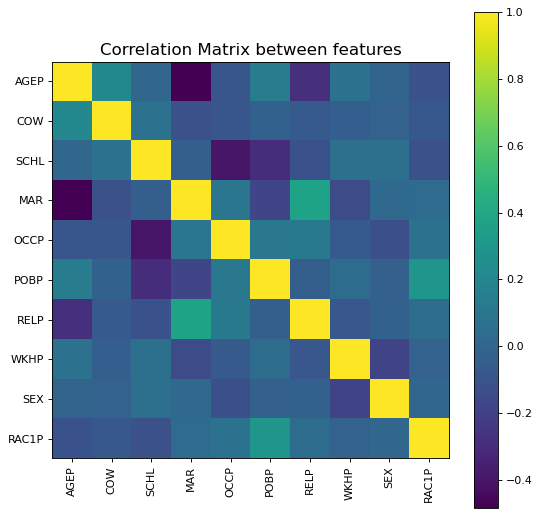

In [11]:
plotCorrelationMatrix(pd.read_csv(features_ca_path), 8)

#### a) Corrélation entre features et label pour les données d'entraînements

Pour les données d'entraîenement : [0.266, 0.054, 0.35, -0.266, -0.341, -0.086, -0.228, 0.338, -0.118, -0.101]


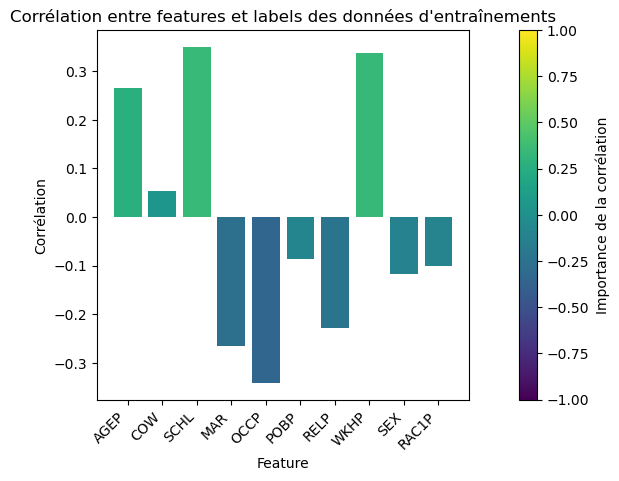

In [14]:
correlations_train = []

X_ca_raw, y_ca = get_data(labels_ca_path, features_ca_path, 1)

features_name = ["AGEP", "COW", "SCHL", "MAR", "OCCP", "POBP", "RELP", "WKHP", "SEX", "RAC1P"]

for i in range(X_ca_raw.shape[1]):
    corr, _ = pearsonr(np.array(X_ca_raw)[:, i], y_ca)
    correlations_train.append(np.round(corr, 3))

print(f"Pour les données d'entraîenement : {correlations_train}")

norm = mcolors.Normalize(vmin=-1, vmax=1)
colors = plt.cm.viridis(norm(correlations_train))

plt.bar(features_name, correlations_train, color=colors)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.1)
cbar.set_label('Importance de la corrélation')
plt.xticks(rotation= 45, ha="right")
plt.ylabel('Corrélation')
plt.xlabel('Feature')
plt.title("Corrélation entre features et labels des données d'entraînements")

plt.show()

#### b) Corrélation entre chaque feature et le label prédit pour les différents modèles

SVM : [0.301, 0.051, 0.435, -0.291, -0.449, -0.115, -0.266, 0.388, -0.112, -0.115]
Random Forest : [0.285, 0.069, 0.447, -0.316, -0.384, -0.117, -0.288, 0.378, -0.123, -0.131]
Ada Boost : [0.317, 0.064, 0.418, -0.322, -0.366, -0.138, -0.297, 0.411, -0.112, -0.158]
Gradient Boosting : [0.303, 0.054, 0.431, -0.313, -0.359, -0.118, -0.292, 0.44, -0.12, -0.125]


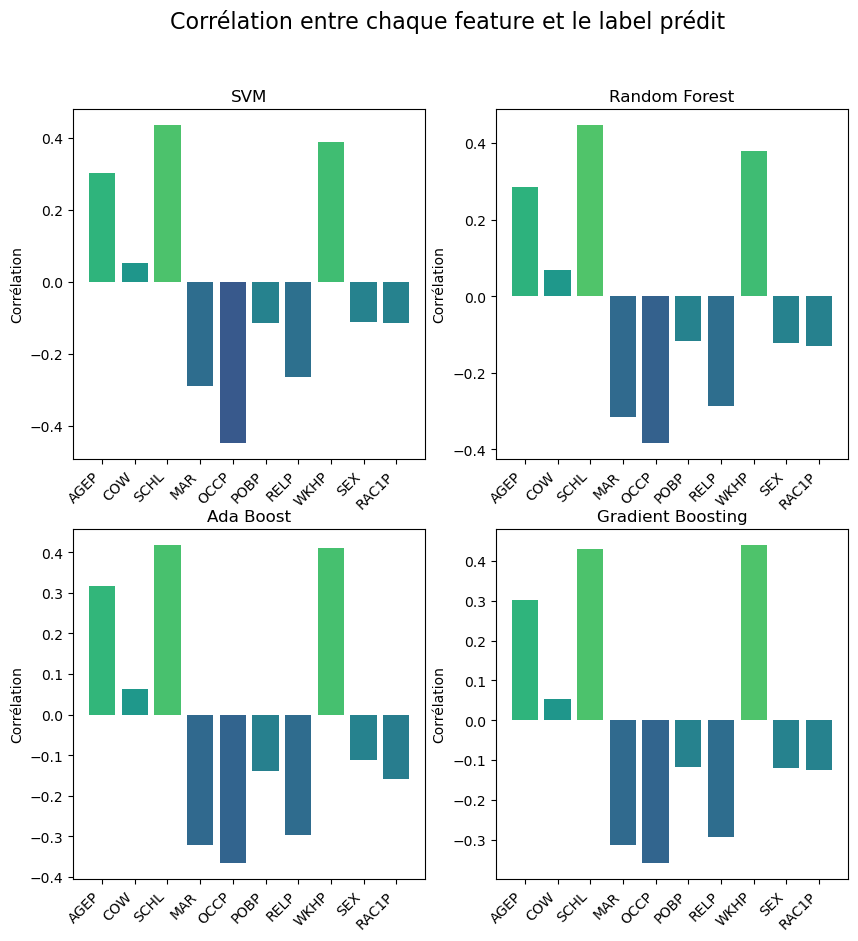

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Corrélation entre chaque feature et le label prédit', fontsize=16)

_, X_test_raw, _, y_test = train_test_split(X_ca_raw, y_ca, test_size=0.2, random_state=5)

X_test = pipeline.transform(X_test_raw)

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    correlations_pred = []
    for i in range(X_test_raw.shape[1]):
        corr, _ = pearsonr(np.array(X_test_raw)[:, i], y_pred)
        correlations_pred.append(np.round(corr, 3))
    
    print(f"{name} : {correlations_pred}")
    
    row, col = divmod(idx, 2)

    ax = axes[row, col]

    norm = mcolors.Normalize(vmin=-1, vmax=1)
    colors = plt.cm.viridis(norm(correlations_pred))
    ax.set_xticks(np.arange(len(features_name)))

    ax.bar(features_name, correlations_pred, color=colors)
    ax.set_xticklabels(features_name, rotation=45, ha="right")
    ax.set_ylabel('Corrélation')
    ax.set_title(f"{name}")

plt.show()

#### c) Feature importance 

In [12]:
X, y = get_data(labels_ca_path, features_ca_path, 0.05)
X_processed = StandardScaler().fit_transform(X)
# Séparation des données en un train set, test set et validation set
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=5)

models = {"SVM": LinearSVC(C=0.05, loss="squared_hinge", tol=0.01),
          "Random Forest": RandomForestClassifier(criterion="entropy", max_features="log2", n_estimators=100),
          "Ada Boost": AdaBoostClassifier(learning_rate=1, n_estimators=100),
          "Gradient Boosting": GradientBoostingClassifier(criterion="friedman_mse", learning_rate=0.2, loss="log_loss", n_estimators=200)}

SVM : [0.02501917 0.00097112 0.06815742 0.00314337 0.03276259 0.00309226
 0.00925121 0.06779964 0.00966011 0.00012778]
Random Forest : [0.14267825 0.03667263 0.14730386 0.04022489 0.1726297  0.07094301
 0.08913877 0.17247636 0.04807053 0.02622029]
Ada Boost : [0.03626374 0.00286225 0.0472783  0.0008689  0.04750831 0.00600562
 0.01834909 0.0682852  0.0039356  0.        ]
Gradient Boosting : [0.06120624 0.01270125 0.05164835 0.00250447 0.08711986 0.01295681
 0.02062356 0.08783542 0.00610785 0.00378226]


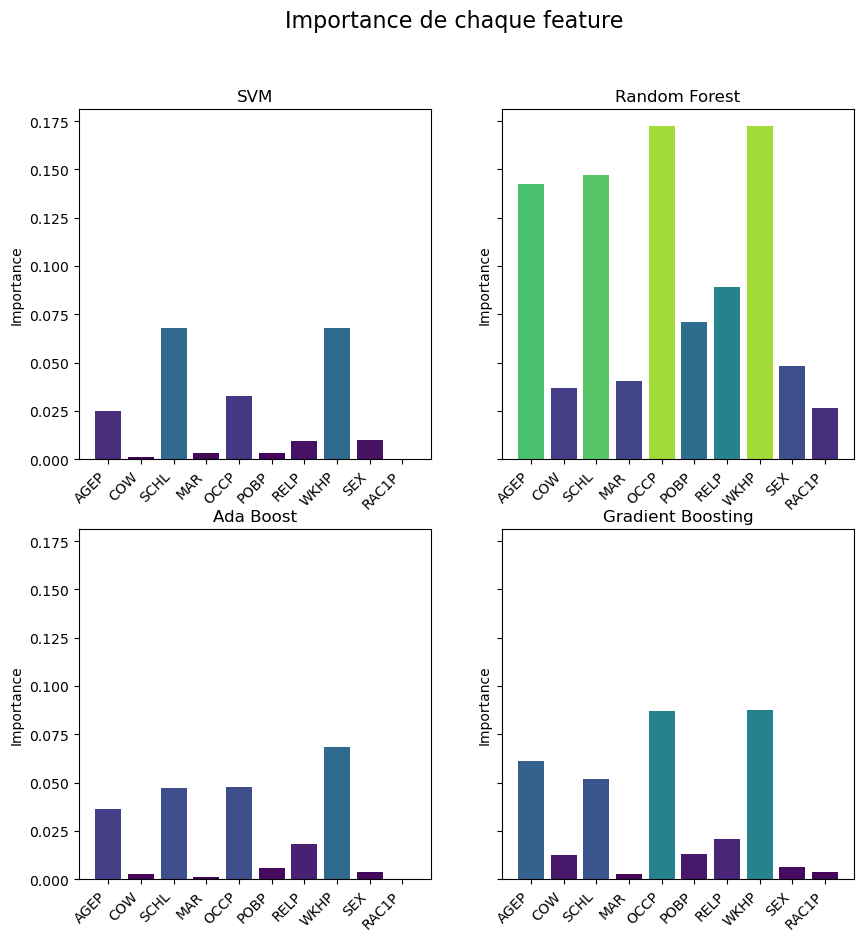

In [15]:
from sklearn.inspection import permutation_importance

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
fig.suptitle('Importance de chaque feature', fontsize=16)

for idx, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    res = permutation_importance(model, X_train, y_train)
    
    print(f"{name} : {res['importances_mean']}")
    
    row, col = divmod(idx, 2)

    ax = axes[row, col]

    norm = mcolors.Normalize(vmin=0, vmax=0.2)
    colors = plt.cm.viridis(norm(res['importances_mean']))

    ax.bar(features_name, res['importances_mean'], color=colors)
    ax.set_xticks(np.arange(len(features_name)))
    ax.set_xticklabels(features_name, rotation=45, ha="right")

    ax.set_ylabel('Importance')
    ax.set_title(f"{name}")

plt.show()

### 2/ Equité des modèles

In [16]:
def get_data_group(labels_path, features_path, group_path, size=0.05):
    features = pd.read_csv(features_path)
    labels = pd.read_csv(labels_path)
    group = np.array(pd.read_csv(group_path))

    X_all, y_all, G_all = shuffle(features, labels, group, random_state=3)
    # only use the first N samples to limit training time
    num_samples = int(len(X_all) * size)
    X, y, G = X_all[:num_samples], y_all[:num_samples], G_all[:num_samples]
    
    y = np.array(y).reshape(-1)
    G = np.array(G).reshape(-1)
    
    return np.array(X), y, G

#### i) Feature SEX

In [20]:
X, y, group_sex = get_data_group(labels_ca_path, features_ca_path, group_sex_path, 1)
X_processed = StandardScaler().fit_transform(X)
# Séparation des données en un train set, test set et validation set
X_train, X_test, y_train, y_test, group_sex_train, group_sex_test = train_test_split(X_processed, y, group_sex, test_size=0.2, random_state=5, shuffle=False)

models = {"SVM": LinearSVC(C=0.05, loss="squared_hinge", tol=0.01),
          "Random Forest": RandomForestClassifier(criterion="entropy", max_features="log2", n_estimators=100),
          "Ada Boost": AdaBoostClassifier(learning_rate=1, n_estimators=100),
          "Gradient Boosting": GradientBoostingClassifier(criterion="friedman_mse", learning_rate=0.2, loss="log_loss", n_estimators=200)}

for model in models.values():
    model.fit(X_train, y_train)

#### a) Confusion matrix, statistical parity et equal opportunity pour chaque valeur de l'attribut SEX et pour chaque modèle

In [21]:
X_male_train = [X_train[i] for i in range(X_train.shape[0]) if group_sex_train[i] == 1]
y_male_train = [y_train[i] for i in range(len(y_train)) if group_sex_train[i] == 1]
X_female_train = [X_train[i] for i in range(X_train.shape[0]) if group_sex_train[i] == 2]
y_female_train = [y_train[i] for i in range(len(y_train)) if group_sex_train[i] == 2]
X_male_test = [X_test[i] for i in range(X_test.shape[0]) if group_sex_test[i] == 1]
y_male_test = [y_test[i] for i in range(len(y_test)) if group_sex_test[i] == 1]
X_female_test = [X_test[i] for i in range(X_test.shape[0]) if group_sex_test[i] == 2]
y_female_test = [y_test[i] for i in range(len(y_test)) if group_sex_test[i] == 2]

In [34]:
def print_equity_stats(y_male_pred, y_male, y_female_pred, y_female):
    # Confusion matrix
    conf_matrix_male = np.array(confusion_matrix(y_male, y_male_pred))
    conf_matrix_female = np.array(confusion_matrix(y_female, y_female_pred))
    print(f"Confusion Matrix : \n male = \n{conf_matrix_male}\n female = \n{conf_matrix_female}")
    # Statistical Parity: comparer les taux de prédictions positives
    stat_parity_male = np.round(np.sum(conf_matrix_male[:, 0]) / np.sum(conf_matrix_male), 3)
    stat_parity_female = np.round(np.sum(conf_matrix_female[:, 0]) / np.sum(conf_matrix_female), 3)

    print(f"Statistical Parity : \nFor male : {stat_parity_male}\nFor female : {stat_parity_female}\n"
          f"Ratio (male/female) : {np.round(stat_parity_male / stat_parity_female, 3)}")

    # Equal Opportunity : comparer les taux de vrais positifs
    equal_opportunity_male = np.round(conf_matrix_male[0, 0] / sum(conf_matrix_male[0]), 3)
    equal_opportunity_female = np.round(conf_matrix_female[0, 0] / sum(conf_matrix_female[0]), 3)

    print(f"Equal Opportunity : \nFor male : {equal_opportunity_male}\nFor female : {equal_opportunity_female}\n"
          f"Ratio (male/female) : {np.round(equal_opportunity_male / equal_opportunity_female, 3)}")

    # Predictive Equality : comparer les taux de faux positifs
    predictive_equality_male = np.round(conf_matrix_male[1, 0] / sum(conf_matrix_male[1]), 3)
    predictive_equality_female = np.round(conf_matrix_female[1, 0] / sum(conf_matrix_female[1]), 3)

    print(f"Predictive Equality : \nFor male : {predictive_equality_male}\nFor female : {predictive_equality_female}\n"
          f"Ratio (male/female) : {np.round(predictive_equality_male / predictive_equality_female, 3)}")

In [28]:
for name, model in models.items():
    print(f"\n{name} : \n")
    # TRAIN
    print("\nTRAIN SET\n")
    y_male_pred_train = model.predict(X_male_train)
    y_female_pred_train = model.predict(X_female_train)
    print_equity_stats(y_male_pred_train, y_male_train, y_female_pred_train, y_female_train)

    # TEST
    print("\nTEST SET\n")
    y_male_pred_test = model.predict(X_male_test)
    y_female_pred_test = model.predict(X_female_test)
    print_equity_stats(y_male_pred_test, y_male_test, y_female_pred_test, y_female_test)


SVM : 


TRAIN SET

Confusion Matrix : 
 male = 
[[34760  9351]
 [ 8802 29733]]
 female = 
[[41685  6359]
 [ 9172 16670]]
Statistical Parity : 
For male : 0.527
For female : 0.688
Ratio (male/female) : 0.766
Equal Opportunity : 
For male : 0.788
For female : 0.868
Ratio (male/female) : 0.908
Predictive Equality : 
For male : 0.228
For female : 0.355
Ratio (male/female) : 0.642

TEST SET

Confusion Matrix : 
 male = 
[[8736 2367]
 [2222 7340]]
 female = 
[[10458  1614]
 [ 2388  4008]]
Statistical Parity : 
For male : 0.53
For female : 0.696
Ratio (male/female) : 0.761
Equal Opportunity : 
For male : 0.787
For female : 0.866
Ratio (male/female) : 0.909
Predictive Equality : 
For male : 0.232
For female : 0.373
Ratio (male/female) : 0.622

Random Forest : 


TRAIN SET

Confusion Matrix : 
 male = 
[[44025    86]
 [   83 38452]]
 female = 
[[47962    82]
 [   83 25759]]
Statistical Parity : 
For male : 0.534
For female : 0.65
Ratio (male/female) : 0.822
Equal Opportunity : 
For male : 0.9

#### b) Confusion matrix, statistical parity et equal opportunity pour chaque modèle avec le dataset sans la feature SEX

In [29]:
models = {"SVM": LinearSVC(max_iter=10000, C=0.5, fit_intercept=True, loss="hinge", tol=0.001),
          "Random Forest": RandomForestClassifier(criterion="entropy", max_features="log2", n_estimators=200),
          "Ada Boost": AdaBoostClassifier(learning_rate=1, n_estimators=100),
          "Gradient Boosting": GradientBoostingClassifier(criterion="friedman_mse", learning_rate=0.2, loss="log_loss",
                                                          max_depth=3, n_estimators=100)}

X, y, group_sex = get_data_group(labels_ca_path, features_ca_without_sex_path, group_sex_path, 1)
X_processed = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test, group_sex_train, group_sex_test = train_test_split(X_processed, y, group_sex, test_size=0.2, random_state=5, shuffle=False)



X_male_train = [X_train[i] for i in range(X_train.shape[0]) if group_sex_train[i] == 1]
y_male_train = [y_train[i] for i in range(len(y_train)) if group_sex_train[i] == 1]
X_female_train = [X_train[i] for i in range(X_train.shape[0]) if group_sex_train[i] == 2]
y_female_train = [y_train[i] for i in range(len(y_train)) if group_sex_train[i] == 2]
X_male_test = [X_test[i] for i in range(X_test.shape[0]) if group_sex_test[i] == 1]
y_male_test = [y_test[i] for i in range(len(y_test)) if group_sex_test[i] == 1]
X_female_test = [X_test[i] for i in range(X_test.shape[0]) if group_sex_test[i] == 2]
y_female_test = [y_test[i] for i in range(len(y_test)) if group_sex_test[i] == 2]

for name, model in models.items():
    model.fit(X_train, y_train)

In [35]:
for name, model in models.items():
    print(f"\n#{name} : \n")

    # TRAIN
    print("TRAIN SET")
    y_male_pred_train = model.predict(X_male_train)
    y_female_pred_train = model.predict(X_female_train)
    print_equity_stats(y_male_pred_train, y_male_train, y_female_pred_train, y_female_train)

    # TEST
    print("\nTEST SET")
    y_male_pred_test = model.predict(X_male_test)
    y_female_pred_test = model.predict(X_female_test)
    print_equity_stats(y_male_pred_test, y_male_test, y_female_pred_test, y_female_test)


#SVM : 

TRAIN SET
Confusion Matrix : 
 male = 
[[36926  7185]
 [11051 27484]]
 female = 
[[38471  9573]
 [ 6190 19652]]
Statistical Parity : 
For male : 0.581
For female : 0.604
Ratio (male/female) : 0.962
Equal Opportunity : 
For male : 0.837
For female : 0.801
Ratio (male/female) : 1.045
Predictive Equality : 
For male : 0.287
For female : 0.24
Ratio (male/female) : 1.196

TEST SET
Confusion Matrix : 
 male = 
[[9286 1817]
 [2799 6763]]
 female = 
[[9649 2423]
 [1613 4783]]
Statistical Parity : 
For male : 0.585
For female : 0.61
Ratio (male/female) : 0.959
Equal Opportunity : 
For male : 0.836
For female : 0.799
Ratio (male/female) : 1.046
Predictive Equality : 
For male : 0.293
For female : 0.252
Ratio (male/female) : 1.163

#Random Forest : 

TRAIN SET
Confusion Matrix : 
 male = 
[[44010   101]
 [  121 38414]]
 female = 
[[47899   145]
 [   87 25755]]
Statistical Parity : 
For male : 0.534
For female : 0.649
Ratio (male/female) : 0.823
Equal Opportunity : 
For male : 0.998
For 

#### i) Feature RAC1P

In [17]:
X, y, group_race = get_data_group(labels_ca_path, features_ca_path, group_race_path, 1)
X_processed = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test, group_race_train, group_race_test = train_test_split(X_processed, y, group_race, test_size=0.2, random_state=5, shuffle=False)


models = {"SVM": LinearSVC(C=0.05, loss="squared_hinge", tol=0.01),
          "Random Forest": RandomForestClassifier(criterion="entropy", max_features="log2", n_estimators=100),
          "Ada Boost": AdaBoostClassifier(learning_rate=1, n_estimators=100),
          "Gradient Boosting": GradientBoostingClassifier(criterion="friedman_mse", learning_rate=0.2, loss="log_loss", n_estimators=200)}

for model in models.values():
    model.fit(X_train, y_train)

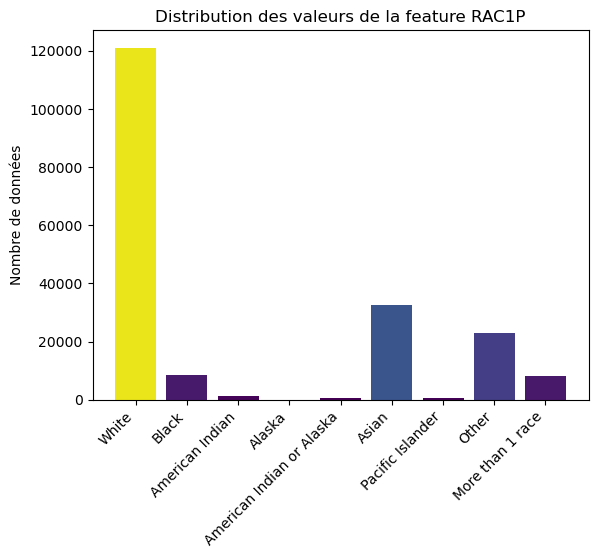

{1: 121006, 2: 8557, 3: 1294, 4: 13, 5: 450, 6: 32709, 7: 637, 8: 22793, 9: 8206}


In [18]:
from collections import Counter

group_race = np.array(pd.read_csv(group_race_path)).reshape(-1)

name_possible_race = ["White", "Black", "American Indian", "Alaska", "American Indian or Alaska",
                      "Asian", "Pacific Islander", "Other", "More than 1 race"]

repartition = dict(sorted(dict(Counter(list(group_race))).items()))

norm = mcolors.Normalize(vmin=0, vmax=125000)
colors = plt.cm.viridis(norm(list(repartition.values())))

plt.bar(name_possible_race, repartition.values(), color=colors)

plt.xticks(rotation= 45, ha="right")

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)

plt.ylabel('Nombre de données')
plt.title("Distribution des valeurs de la feature RAC1P")

plt.show()

print(repartition)

#### a)  Confusion matrix, statistical parity et equal opportunity pour chaque valeur de l'attribut RAC1P et pour chaque modèle

In [38]:
X_white_train = [X_train[i] for i in range(X_train.shape[0]) if group_race_train[i] == 1]
y_white_train = [y_train[i] for i in range(len(y_train)) if group_race_train[i] == 1]
X_others_train = [X_train[i] for i in range(X_train.shape[0]) if group_race_train[i] != 1]
y_others_train = [y_train[i] for i in range(len(y_train)) if group_race_train[i] != 1]
X_white_test = [X_test[i] for i in range(X_test.shape[0]) if group_race_test[i] == 1]
y_white_test = [y_test[i] for i in range(len(y_test)) if group_race_test[i] == 1]
X_others_test = [X_test[i] for i in range(X_test.shape[0]) if group_race_test[i] != 1]
y_others_test = [y_test[i] for i in range(len(y_test)) if group_race_test[i] != 1]

In [27]:
def print_equity_stats_RAC1P(y_white_pred, y_white, y_others_pred, y_others):
    # Confusion matrix
    conf_matrix_white = np.array(confusion_matrix(y_white, y_white_pred))
    conf_matrix_others = np.array(confusion_matrix(y_others, y_others_pred))
    print(f"Confusion Matrix : \n white = \n{conf_matrix_white}\n others = \n{conf_matrix_others}")
    
    # Statistical Parity: compare positive prediction rates
    stat_parity_white = np.round(np.sum(conf_matrix_white[:, 0]) / np.sum(conf_matrix_white), 3)
    stat_parity_others = np.round(np.sum(conf_matrix_others[:, 0]) / np.sum(conf_matrix_others), 3)

    print(f"Statistical Parity : \nFor white : {stat_parity_white}\nFor others : {stat_parity_others}\n"
          f"Ratio (white/others) : {np.round(stat_parity_white / stat_parity_others, 3)}")

    # Equal Opportunity: compare true positive rates
    equal_opportunity_white = np.round(conf_matrix_white[0, 0] / sum(conf_matrix_white[0]), 3)
    equal_opportunity_others = np.round(conf_matrix_others[0, 0] / sum(conf_matrix_others[0]), 3)

    print(f"Equal Opportunity : \nFor white : {equal_opportunity_white}\nFor others : {equal_opportunity_others}\n"
          f"Ratio (white/others) : {np.round(equal_opportunity_white / equal_opportunity_others, 3)}")

    # Predictive Equality: compare false positive rates
    predictive_equality_white = np.round(conf_matrix_white[1, 0] / sum(conf_matrix_white[1]), 3)
    predictive_equality_others = np.round(conf_matrix_others[1, 0] / sum(conf_matrix_others[1]), 3)

    print(f"Predictive Equality : \nFor white : {predictive_equality_white}\nFor others : {predictive_equality_others}\n"
          f"Ratio (white/others) : {np.round(predictive_equality_white / predictive_equality_others, 3)}")


In [47]:
for name, model in models.items():
    print(f"\n{name} : \n")
    # TRAIN
    print("\nTRAIN SET\n")
    y_white_pred_train = model.predict(X_white_train)
    y_others_pred_train = model.predict(X_others_train)
    print_equity_stats_RAC1P(y_white_pred_train, y_white_train, y_others_pred_train, y_others_train)

    # TEST
    print("\nTEST SET\n")
    y_white_pred_test = model.predict(X_white_test)
    y_others_pred_test = model.predict(X_others_test)
    print_equity_stats_RAC1P(y_white_pred_test, y_white_test, y_others_pred_test, y_others_test)


SVM : 


TRAIN SET

Confusion Matrix : 
 white = 
[[43725 10162]
 [10736 32213]]
 others = 
[[32719  5549]
 [ 7235 14193]]
Statistical Parity : 
For white : 0.562
For others : 0.669
Ratio (white/others) : 0.84
Equal Opportunity : 
For white : 0.811
For others : 0.855
Ratio (white/others) : 0.949
Predictive Equality : 
For white : 0.25
For others : 0.338
Ratio (white/others) : 0.74

TEST SET

Confusion Matrix : 
 white = 
[[10933  2536]
 [ 2795  7906]]
 others = 
[[8261 1445]
 [1815 3442]]
Statistical Parity : 
For white : 0.568
For others : 0.673
Ratio (white/others) : 0.844
Equal Opportunity : 
For white : 0.812
For others : 0.851
Ratio (white/others) : 0.954
Predictive Equality : 
For white : 0.261
For others : 0.345
Ratio (white/others) : 0.757

Random Forest : 


TRAIN SET

Confusion Matrix : 
 white = 
[[53754   133]
 [  118 42831]]
 others = 
[[38225    43]
 [   42 21386]]
Statistical Parity : 
For white : 0.556
For others : 0.641
Ratio (white/others) : 0.867
Equal Opportunity :

#### b) Confusion matrix, statistical parity et equal opportunity pour chaque modèle avec le dataset sans la feature RAC1P

In [19]:
models = {"SVM": LinearSVC(max_iter=10000, C=0.5, fit_intercept=True, loss="hinge", tol=0.001),
          "Random Forest": RandomForestClassifier(criterion="entropy", max_features="log2", n_estimators=200),
          "Ada Boost": AdaBoostClassifier(learning_rate=1, n_estimators=100),
          "Gradient Boosting": GradientBoostingClassifier(criterion="friedman_mse", learning_rate=0.2, loss="log_loss",
                                                          max_depth=3, n_estimators=100)}

X, y, group_race = get_data_group(labels_ca_path, features_ca_without_race_path, group_race_path, 1)
X_processed = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test, group_race_train, group_race_test = train_test_split(X_processed, y, group_race, test_size=0.2, random_state=5, shuffle=False)


X_white_train = [X_train[i] for i in range(X_train.shape[0]) if group_race_train[i] == 1]
y_white_train = [y_train[i] for i in range(len(y_train)) if group_race_train[i] == 1]
X_others_train = [X_train[i] for i in range(X_train.shape[0]) if group_race_train[i] != 1]
y_others_train = [y_train[i] for i in range(len(y_train)) if group_race_train[i] != 1]
X_white_test = [X_test[i] for i in range(X_test.shape[0]) if group_race_test[i] == 1]
y_white_test = [y_test[i] for i in range(len(y_test)) if group_race_test[i] == 1]
X_others_test = [X_test[i] for i in range(X_test.shape[0]) if group_race_test[i] != 1]
y_others_test = [y_test[i] for i in range(len(y_test)) if group_race_test[i] != 1]

for name, model in models.items():
    model.fit(X_train, y_train)

In [26]:
for name, model in models.items():
    print(f"\n#{name} : \n")

    # TRAIN
    print("TRAIN SET")
    y_white_pred_train = model.predict(X_white_train)
    y_others_pred_train = model.predict(X_others_train)
    print_equity_stats_RAC1P(y_white_pred_train, y_white_train, y_others_pred_train, y_others_train)

    # TEST
    print("\nTEST SET")
    y_white_pred_test = model.predict(X_white_test)
    y_others_pred_test = model.predict(X_others_test)
    print_equity_stats_RAC1P(y_white_pred_test, y_white_test, y_others_pred_test, y_others_test)



#SVM : 

TRAIN SET
Confusion Matrix : 
 white = 
[[43860 10027]
 [10776 32173]]
 others = 
[[32336  5932]
 [ 6712 14716]]
Statistical Parity : 
For white : 0.564
For others : 0.654
Ratio (white/others) : 0.862
Equal Opportunity : 
For white : 0.814
For others : 0.845
Ratio (white/others) : 0.963
Predictive Equality : 
For white : 0.251
For others : 0.313
Ratio (white/others) : 0.802

TEST SET
Confusion Matrix : 
 white = 
[[10950  2519]
 [ 2833  7868]]
 others = 
[[8161 1545]
 [1679 3578]]
Statistical Parity : 
For white : 0.57
For others : 0.658
Ratio (white/others) : 0.866
Equal Opportunity : 
For white : 0.813
For others : 0.841
Ratio (white/others) : 0.967
Predictive Equality : 
For white : 0.265
For others : 0.319
Ratio (white/others) : 0.831

#Random Forest : 

TRAIN SET
Confusion Matrix : 
 white = 
[[53716   171]
 [  186 42763]]
 others = 
[[38177    91]
 [  127 21301]]
Statistical Parity : 
For white : 0.557
For others : 0.642
Ratio (white/others) : 0.868
Equal Opportunity : 